# Reference:
https://www.kaggle.com/code/dansbecker/xgboost <br>
https://ithelp.ithome.com.tw/articles/10273094 <br>
https://stackoverflow.com/questions/51904422/how-can-i-use-r2-as-an-evaluation-metric-when-modeling

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV

In [3]:
# origin dataset
# import dataset
df_train = pd.read_excel("Data_Train.xlsx", engine='openpyxl')
df_train
# print(df_train.dtypes)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [4]:
# Preprocessing

# drop null value
df_train.dropna(inplace=True)

# drop duplicates
df_train.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df_train["Dep_hour"] = pd.to_datetime(df_train["Dep_Time"]).dt.hour
df_train["Dep_minute"] = pd.to_datetime(df_train["Dep_Time"]).dt.minute
df_train = df_train.drop(columns="Dep_Time")

# Arrival_Time
df_train["Arr_hour"] = pd.to_datetime(df_train["Arrival_Time"]).dt.hour
df_train["Arr_minute"] = pd.to_datetime(df_train["Arrival_Time"]).dt.minute
df_train = df_train.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df_train["Date_of_Journey_Year"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df_train["Date_of_Journey_Month"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.month
df_train["Date_of_Journey_Day"] = pd.to_datetime(
    df_train["Date_of_Journey"], format="%d/%m/%Y").dt.day
df_train = df_train.drop(columns="Date_of_Journey")


# convert Duration into minute
df_train['Duration'] = df_train['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# Encode categorical attributes

# Select categorical data
df_train_categorical = df_train[['Airline', 'Source', 'Destination']]
df_train.drop(["Airline","Source", "Destination"], axis=1, inplace=True)

# Use OneHotEncoder
df_train_categorical = pd.get_dummies(df_train_categorical, drop_first=True)

# Concat categorical and numerical data
train_preprocessed = pd.concat([df_train, df_train_categorical], axis=1)
train_target = df_train['Price']

# Drop 'Price' because price is the target variable
train_preprocessed.drop(['Price'], axis=1, inplace=True)

train_preprocessed

,Route,Duration,Total_Stops,Additional_Info,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,BLR → DEL,170,non-stop,No info,22,20,1,10,2019,3,...,0,0,0,0,0,0,0,0,0,1
1,CCU → IXR → BBI → BLR,445,2 stops,No info,5,50,13,15,2019,5,...,0,0,0,1,0,0,0,0,0,0
2,DEL → LKO → BOM → COK,1140,2 stops,No info,9,25,4,25,2019,6,...,0,0,1,0,0,1,0,0,0,0
3,CCU → NAG → BLR,325,1 stop,No info,18,5,23,30,2019,5,...,0,0,0,1,0,0,0,0,0,0
4,BLR → NAG → DEL,285,1 stop,No info,16,50,21,35,2019,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,CCU → BLR,150,non-stop,No info,19,55,22,25,2019,4,...,0,0,0,1,0,0,0,0,0,0
10679,CCU → BLR,155,non-stop,No info,20,45,23,20,2019,4,...,0,0,0,1,0,0,0,0,0,0
10680,BLR → DEL,180,non-stop,No info,8,20,11,20,2019,4,...,0,0,0,0,0,0,1,0,0,0
10681,BLR → DEL,160,non-stop,No info,11,30,14,10,2019,3,...,0,0,0,0,0,0,0,0,0,1


## Begin of Work

In [58]:
# score function
def cal_score(model):
    score = model.score(test_X, test_y)
    print('R-squared: ' + str(score*100) + '%')

    # MAE
    predictions = model.predict(test_X)
    print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

    # MSE
    predictions = model.predict(test_X)
    print("Mean Squared Error : " + str(mean_squared_error(predictions, test_y)))

    # RMSE
    predictions = model.predict(test_X)
    print("Root Mean Squared Error : " + str(mean_squared_error(predictions, test_y, squared=False)))

In [113]:
# parameter range
n_estimators_range = list(np.arange(100,501,100))
leaning_rate_range = list(np.arange(0.0,0.5,0.05))
max_depth_range = list(np.arange(5,20,1))

parameter_grid = {"n_estimators": n_estimators_range, 
                  "learning_rate": leaning_rate_range,
                  "max_depth": max_depth_range,}

In [156]:
## Train 1

train_data = copy.deepcopy(train_preprocessed)
train_data['Total_Stops'] = train_data['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})
train_data.drop(["Route", "Additional_Info"], axis=1, inplace=True) # use later: Total_Stops

train_X, test_X, train_y, test_y = train_test_split(train_data, train_target, test_size=0.25, random_state=123)

xgboost_model = XGBRegressor()

estimator_gs = RandomizedSearchCV(xgboost_model, parameter_grid, scoring="neg_mean_squared_error", cv=15) #RandomizedSearchCV
estimator_gs.fit(train_X, train_y)
estimator_gs.best_params_

# Add silent=True to avoid printing out updates with each cycle
# xgboost_model.fit(train_X, train_y, verbose=False)

{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05}

In [159]:
# estimator_gs = RandomizedSearchCV(xgboost_model, parameter_grid, scoring="r2", cv=15)
# estimator_gs.fit(train_X, train_y)
# estimator_gs.best_params_

In [127]:
# estimator_gs = GridSearchCV(xgboost_model, parameter_grid, scoring="neg_mean_squared_error", cv=3)
# estimator_gs.fit(train_X, train_y)
# estimator_gs.best_params_

In [128]:
# estimator_gs = GridSearchCV(xgboost_model, parameter_grid, scoring="r2", cv=3)
# estimator_gs.fit(train_X, train_y)
# estimator_gs.best_params_

In [57]:
# train_data = copy.deepcopy(train_preprocessed)
# train_data.drop(["Route","Total_Stops", "Additional_Info"], axis=1, inplace=True) # use later: Total_Stops
# train_data

# train_X, test_X, train_y, test_y = train_test_split(train_data, train_target, test_size=0.25)

# xgboost_model = XGBRegressor()

# estimator_gs = GridSearchCV(xgboost_model, parameter_grid, scoring="r2", cv=3)
# accuracy_cv = cross_val_score(estimator_gs, train_X, train_y, cv=3, scoring="r2")
# accuracy_cv

In [173]:
#train model based on the best parameter
# print("---Model 1 ---")
xgboost_model_best = XGBRegressor(n_estimators = 500, learning_rate = 0.05, max_depth=8, n_jobs=-1)
xgboost_model_best.fit(train_X, train_y, early_stopping_rounds=5,eval_set=[(test_X, test_y)], verbose=False)
cal_score(xgboost_model_best)
print("---Model 2 ---")
xgboost_model = XGBRegressor()
xgboost_model.fit(train_X, train_y, early_stopping_rounds=5,eval_set=[(test_X, test_y)], verbose=False)
cal_score(xgboost_model)

R-squared: 84.84395102514296%
Mean Absolute Error : 1185.1067463819404
Mean Squared Error : 2940640.271599383
Mean Squared Error : 1714.8295167740096
---Model 2 ---
R-squared: 83.53652304917651%
Mean Absolute Error : 1233.2202370553207
Mean Squared Error : 3194312.938184236
Mean Squared Error : 1787.2640930159807


# Performace comparison
## Based Model
r2 = 83.53 , MAE = 1233.22

## Tuning Model
max_depth = 8, n_estimators = 500, learning_rate = 0.05 => r2 = 84.84 , MAE = 1185.10 <br>

In [15]:
# R-squared
score = my_model.score(test_X, test_y)
print('R-squared: ' + str(score*100) + '%')

# MAE
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

# MSE
predictions = my_model.predict(test_X)
print("Mean Squared Error : " + str(mean_squared_error(predictions, test_y)))

# RMSE
predictions = my_model.predict(test_X)
print("Mean Squared Error : " + str(mean_squared_error(predictions, test_y, squared=False)))

R-squared: 83.38982496052745%
Mean Absolute Error : 1241.1161079523395
Mean Squared Error : 3799600.995680946
Mean Squared Error : 1949.2565238266989


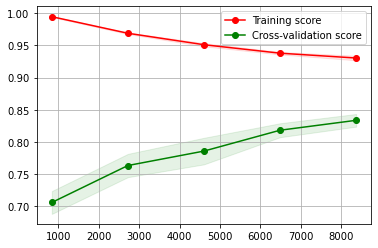

In [19]:
# learning Curve
train_sizes, train_scores, test_scores = learning_curve(my_model, train_data, train_target, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.draw()
plt.show()